
# Cleaning anomalies in time series per region slug



## Load  libraries

In [1]:
# %load first_cell.py
%reload_ext autoreload
%autoreload 2
from pathlib import Path

# system paths
import sys
home = str(Path.home())
sys.path = sys.path + [f'{home}/.conda/envs/norm_env/lib/python37.zip', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/lib-dynload', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/site-packages']
sys.prefix = '/home/soniame/.conda/envs/norm_env'
from paths import RAW_PATH, TREAT_PATH, OUTPUT_PATH, FIGURES_PATH

# manipulation libraries
import pandas as pd
import datetime
from siuba import *

# visualization
import plotnine as p9
p9.theme_set(p9.theme_linedraw()) # default theme

# aws connection
import boto3
import awswrangler as wr

# local libraries
from src import utils

In [2]:
conn = utils.connect_athena(path='../configs/athena.yaml')

## Results Batch

In [81]:
cm = str(datetime.datetime.today().strftime("%Y%m%d%H%m"))
cm

'202107120507'

### Daily

#### Experiments of parameters

Experiments with different parameters to test level shift and outliers. Each experiment represents a different pipeline run varying parameters. Each experiment is saved at s3 

In [ ]:
df_list = list()
for k in range(7):
    file = ['ls1', 'ls4', 'ls10', 'ls15', 'ls20', 'ls100', 'lsmix'][k]
    print(file)
    metric = ['', '_ls_4X', '_ls_10X', '_ls_15X', '_ls_20X', '_ls_OFF', '_ls_MIX'][k]
    
    df = pd.read_csv(f"/home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/daily/daily_daily_index_max_{file}.csv")
    df = df[['date', 'region_slug', 'tci_observed', 'tcp_observed', 'tci_clean', 'tcp_clean']] \
        .rename(columns = {'tci_clean':f'tci_cleaned{metric}', 
                           'tcp_clean':f'tcp_cleaned{metric}'}) 
    print(df.shape)
    df_list.append(df)
    
from functools import reduce
df_union = reduce(lambda x, y: pd.merge(x, y, on = ['date', 'region_slug', 'tci_observed', 'tcp_observed']), df_list)
print(df_union.shape)
print(df_union.date.max())
df_union.head(2)    

#### Export to csv

In [ ]:
df_union.describe()
df_union.to_csv(f"/home/soniame/private/smooth/daily_index_index-{cm}.csv", index=False)

In [ ]:
#print(df_union.date.max())
#df_union[df_union.region_slug == 'lima'].tail()

In [ ]:
import plotnine as p9
gg = (p9.ggplot(df_union[df_union.region_slug == 'country_mexico'],
                    p9.aes(x = 'date', y='tci_observed', group = 'region_slug')) 
 + p9.geom_line() 
 + p9.geom_line(p9.aes(y = 'tci_cleaned'), color = 'gray')
 + p9.geom_line(p9.aes(y = 'tci_cleaned_ls_20X'), color = 'red')
 + p9.geom_line(p9.aes(y = 'tci_cleaned_ls_4X'), color = 'blue')
 + p9.geom_line(p9.aes(y = 'tci_cleaned_ls_OFF'), color = 'green')
 + p9.geom_line(p9.aes(y = 'tci_cleaned_ls_MIX'), color = 'orange')
 + p9.geom_line(p9.aes( y='tci_cleaned'), color = 'blue'))
#gg

In [ ]:
df_union_daily.head()

#### Athena historic

**Warning**: run this just to update smoothed data history

File daily_index_index-202105 creates smoothing until May 2021. 
This data is stored at athena database as table `prod_daily_daily_smooth_historical` 

In [ ]:
update_historic = False
df_union_daily = pd.read_csv("/home/soniame/private/smooth/daily_index_index-202105.csv", index_col=0) \
    [['date', 'region_slug', 
      'tci_observed', 'tcp_observed', 
      'tci_cleaned_ls_20X', 'tcp_cleaned_ls_20X']] \
    .rename(columns = {'tci_cleaned_ls_20X':'tci_smoothed', 
                       'tcp_cleaned_ls_20X':'tcp_smoothed'}) 
#df_union_weekly.head(2)


s3_path = "s3://iadbprod-public-stata-as-a-service/spd-sdv-omitnik-waze/corona"
if update_historic:
    res = wr.s3.to_parquet(
            df=df_union_daily,
            path=f"{s3_path}/athena/prod/smooth/prod_daily_daily_smooth_historical",
            dataset=True,
            database='spd_sdv_waze_corona',
            table='prod_daily_daily_smooth_historical',
            mode="overwrite",
            boto3_session=boto3.Session(region_name="us-east-1"),
        )

#### Export update 


In [6]:
prod_version = "202106291106" 
dev_version = "202107120507"

In [83]:
# preview observation
df_prev = pd.read_sql_query(f"""
    select 
        date, region_slug, tci_observed, tcp_observed,  tci_smoothed, tcp_smoothed
    from spd_sdv_waze_corona.prod_daily_daily_smooth_historical""", conn)

In [7]:
# update dates from prod
df_new = pd.read_csv(f"/home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/daily/daily_daily_index_prod_max_ls20-{prod_version}.csv")
df_new = df_new[df_new.date > df_prev.date.max()][['date', 'region_slug', 
                                        'tci_observed', 'tcp_observed', 
                                        'tcp_smooth', 'tci_smooth']] \
        .rename(columns = {'tci_smooth':'tci_smoothed', 
                           'tcp_smooth':'tcp_smoothed'})

NameError: name 'df_prev' is not defined

In [ ]:
df_daily_prod = pd.concat([df_prev, df_new])
#df_daily_prod.head()

In [26]:
#df_daily_prod.sort_values('date').date.unique()
#df_new.sort_values('region_slug').region_slug.unique()

In [85]:
# update dates from dev
df_dev = pd.read_csv(f"/home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/daily/daily_daily_index_dev_max_ls20-{dev_version}.csv")
df_dev = df_dev[['date', 'region_slug', 
                'tci_observed', 'tcp_observed', 
                'tcp_smooth', 'tci_smooth']]  \
        .rename(columns = {'tci_smooth':'tci_smoothed_dev', 
                           'tcp_smooth':'tcp_smoothed_dev',
                           'tci_observed':'tci_observed_dev', 
                           'tcp_observed':'tcp_observed_dev'})
df_dev.head()

,date,region_slug,tci_observed_dev,tcp_observed_dev,tcp_smoothed_dev,tci_smoothed_dev
0,2020-08-09,aguascalientes,1476292,-28.390264,-28.390264,1476292.0
1,2020-11-08,aguascalientes,1506272,-26.936039,-26.936039,1506272.0
2,2021-06-13,aguascalientes,2127337,3.189641,3.189641,2127337.0
3,2021-02-28,aguascalientes,1784194,-13.455020,-13.455020,1784194.0
4,2020-09-27,aguascalientes,1279180,-37.951474,-37.951474,1279180.0


In [35]:
#df_dev.sort_values('date').date.unique()
#df_dev.sort_values('region_slug').region_slug.unique()

In [86]:
print(df_daily_prod.shape)
print(df_dev.shape)

df_daily_update = df_daily_prod.merge(df_dev)
#df_daily_update = df_daily_prod

(38188, 6)
(38776, 6)


In [40]:
#df_daily_update.head()

In [88]:
df_daily_update.to_csv(f"/home/soniame/private/smooth/daily_index_index_update-{cm}.csv", index=False)

print(df_daily_update.date.min())
print(df_daily_update.date.max())

print(df_prev.date.min())
print(df_prev.date.max())

print(df_new.date.min())
print(df_new.date.max())

print(df_dev.date.min())
print(df_dev.date.max())

2020-03-09
2021-06-23
2020-03-09
2021-05-19
2021-05-20
2021-06-23
2020-03-09
2021-07-08


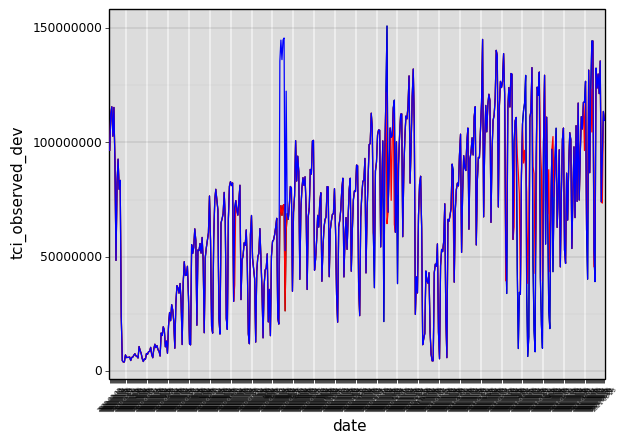

<ggplot: (8770968458473)>

In [92]:
import plotnine as p9
gg = (p9.ggplot(df_daily_update[df_daily_update.region_slug == 'bogota'],
                    p9.aes(x = 'date', y='tci_observed_dev', group = 'region_slug')) 
 + p9.geom_line() 
 + p9.geom_line(p9.aes(y = 'tci_smoothed_dev'), color = 'red')
 + p9.geom_line(p9.aes(y = 'tci_observed'), color = 'blue')
 + p9.theme(axis_text_x=p9.element_text(angle=45, size = 4))
     )
gg

#### Long format

In [93]:
df_daily_update.head(1)

,date,region_slug,tci_observed,tcp_observed,tci_smoothed,tcp_smoothed,tci_observed_dev,tcp_observed_dev,tcp_smoothed_dev,tci_smoothed_dev
0,2020-07-15,aguascalientes,2544527,-10.189667,2544527.0,-10.189667,2544527,-10.189667,-10.189667,2544527.0


In [94]:
from siuba import *
df_update_long = (df_daily_update 
 >> gather('measure', 'value', _["tci_observed":"tci_smoothed_dev"])
)
df_update_long['type'] = 'TCP'
tci_exist = df_update_long['measure'].isin(['tci_observed',  'tci_smoothed', 
                                           'tci_observed_dev', 'tci_smoothed_dev'])
df_update_long['type'][tci_exist] = 'TCI'
#df_update_long.measure.unique()

/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [95]:
df_prev_long = pd.read_csv(f"/home/soniame/private/smooth/daily_daily_index_long-202105.csv", index_col=0)
df_prev_long = df_prev_long[df_prev_long.measure.isin(['tci_observed',  'tcp_observed', 'tci_cleaned', 'tcp_cleaned']) == False]

print(df_prev_long.measure.unique())

df_daily_long = pd.concat([df_prev_long, df_update_long])
print(df_daily_long.measure.unique())
#df_daily_long[(df_daily_long.measure == 'tci_observed') & 
#              (df_daily_long.date == '2020-05-29') &
#              (df_daily_long.region_slug == 'aguascalientes')]

['tci_cleaned_ls_4X' 'tci_cleaned_ls_20X' 'tci_cleaned_ls_10X'
 'tci_cleaned_ls_15X' 'tci_cleaned_ls_OFF' 'tci_cleaned_ls_MIX'
 'tcp_cleaned_ls_4X' 'tcp_cleaned_ls_20X' 'tcp_cleaned_ls_OFF'
 'tcp_cleaned_ls_MIX' 'pc_driven_miles__waze' 'workplace__goo']
['tci_cleaned_ls_4X' 'tci_cleaned_ls_20X' 'tci_cleaned_ls_10X'
 'tci_cleaned_ls_15X' 'tci_cleaned_ls_OFF' 'tci_cleaned_ls_MIX'
 'tcp_cleaned_ls_4X' 'tcp_cleaned_ls_20X' 'tcp_cleaned_ls_OFF'
 'tcp_cleaned_ls_MIX' 'pc_driven_miles__waze' 'workplace__goo'
 'tci_observed' 'tcp_observed' 'tci_smoothed' 'tcp_smoothed'
 'tci_observed_dev' 'tcp_observed_dev' 'tcp_smoothed_dev'
 'tci_smoothed_dev']


In [96]:
# saving the update
df_daily_long.to_csv(f"/home/soniame/private/smooth/daily_daily_index_long-{cm}.csv")
df_daily_long.to_csv(f"/home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/dashboard/daily_daily_index_long-{cm}.csv")


/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 12 rows containing missing values.


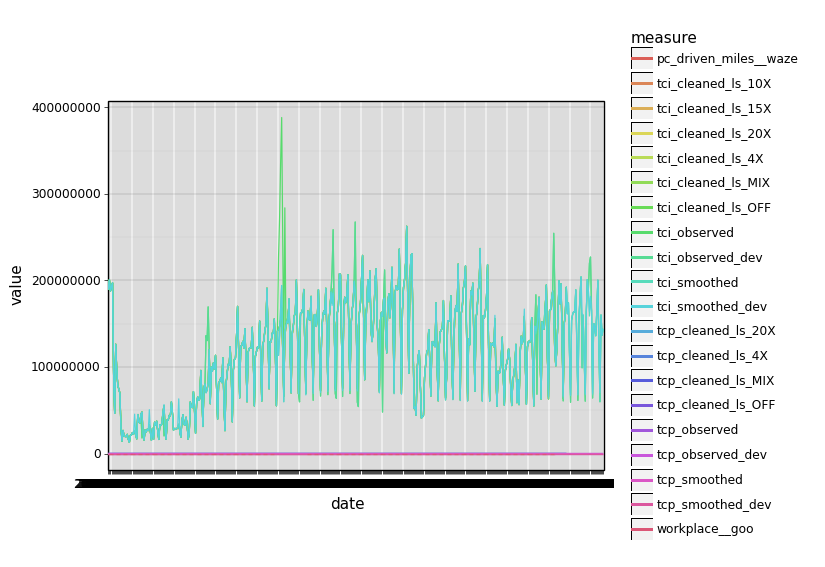

<ggplot: (8770964081005)>

In [98]:
gg = (p9.ggplot(df_daily_long[df_daily_long.region_slug == 'saopaulo'],
                    p9.aes(x = 'date', y='value', 
                           colour = 'measure', group = 'measure')) 
+ p9.geom_line() )
gg

In [ ]:
#df_daily_long.head()
#(df_daily_long 
#>> group_by('measure', 'type')
#>> summarize(date_min = _.date.min(),
#             date_max = _.date.max(), 
#             n_obs = _.date.count())
#)

In [58]:
gg = (p9.ggplot(df_daily_long[(df_daily_long.region_slug == 'country_peru') & 
                              (df_daily_long.type == 'TCI') & 
                              (df_daily_long.date > '2020-08-01') &
                              (df_daily_long.measure.isin(['tci_observed_dev', 'tci_smoothed_dev']))],
                    p9.aes(x = 'date', y='value', 
                           colour = 'measure', group = 'measure')) 
 + p9.geom_line()
 + p9.facet_wrap('region_slug')
 + p9.theme(axis_text_x=p9.element_text(angle=90),
                figure_size=(10, 5) )
)
#gg

In [ ]:
#df_daily_update.sort_values('date').date.unique()

#### Daily dev

In [ ]:
#from src import utils
#conn = utils.connect_athena(path='../configs/athena.yaml')
#qry="""
#select 
#    region_slug, 
#    date(concat(cast(year as varchar), '-', 
#				cast(month as varchar), '-', 
#				cast(day as varchar))) as date,
#    observed as tci_dev, tcp as tcp_dev
#from spd_sdv_waze_corona.dev_daily_daily_index
#where region_type in ('country', 'city');
#"""
#df_daily_dev = pd.read_sql_query(qry, conn)

In [ ]:
#df_daily_dev_long = (df_daily_dev 
#    >> gather('measure', 'value', _["tci_dev":"tcp_dev"]))
#print(df_daily_dev_long.shape)
#regions_in = list(set(df_daily_dev_long.region_slug.unique()) & set(df_daily_long.region_slug.unique()))
#df_daily_dev_long = df_daily_dev_long[df_daily_dev_long.region_slug.isin(regions_in)]
#df_daily_dev_long.shape
#df_daily_dev_long['type'] = 'TCP'
#tci_exist = df_daily_dev_long['measure'].isin(['tci_dev'])
#df_daily_dev_long['type'][tci_exist] = 'TCI'

In [ ]:
#df_daily_long = pd.read_csv("/home/soniame/private/daily_daily_index_long.csv", index_col=0)
#df_daily_long.shape
#df_daily_long_new = pd.concat([df_daily_long, df_daily_dev_long], axis=0)
#df_daily_long_new.to_csv("/home/soniame/private/daily_daily_index_long-dev.csv")

### Weekly

#### Experiments of parameters

In [ ]:
df_list = list()
for k in range(7):
    file = ['ls1', 'ls4', 'ls10', 'ls15', 'ls20', 'ls100', 'lsmix'][k]
    print(file)
    metric = ['', '_ls_4X', '_ls_10X', '_ls_15X', '_ls_20X', '_ls_OFF', '_ls_MIX'][k]
    
    df = pd.read_csv(f"/home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/weekly/weekly_weekly_index_max_{file}.csv")
    df = df[['week', 'days_num', 'date_min', 'region_slug', 
             'tci_observed', 'tcp_observed', 'tci_clean', 'tcp_clean']] \
        .rename(columns = {'tci_clean':f'tci_cleaned{metric}', 
                           'tcp_clean':f'tcp_cleaned{metric}'}) 
    print(df.shape)
    df_list.append(df)
    
from functools import reduce
df_union = reduce(lambda x, y: pd.merge(x, y, on = ['week', 'days_num', 'region_slug', 'date_min', 'tci_observed', 'tcp_observed']), df_list)
print(df_union.shape)
df_union.head(2)    

##### Long format experiments

In [ ]:
df_weekly = pd.read_csv("/home/soniame/private/weekly_weekly_index.csv")
df_weekly.head(2)

In [ ]:
df_weekly_long = (df_weekly 
 >> select('week', 'days_num', 'date_min', 'region_slug', 
           'tci_observed',  'tci_cleaned', 
           'tci_cleaned_ls_4X', 'tci_cleaned_ls_20X',
           'tci_cleaned_ls_10X', 'tci_cleaned_ls_15X',
           'tci_cleaned_ls_OFF', 'tci_cleaned_ls_MIX',
           'tcp_observed', 'tcp_cleaned', 
           'tcp_cleaned_ls_4X', 'tcp_cleaned_ls_20X', 
           'tci_cleaned_ls_10X', 'tci_cleaned_ls_15X',
           'tcp_cleaned_ls_OFF', 'tcp_cleaned_ls_MIX')
 >> gather('measure', 'value', _["tci_observed":"tcp_cleaned_ls_MIX"])
 >> mutate(type = 'TCP')
)
tci_exist = df_weekly_long['measure'].isin(['tci_observed',  'tci_cleaned', 
           'tci_cleaned_ls_4X', 'tci_cleaned_ls_20X', 
           'tci_cleaned_ls_10X', 'tci_cleaned_ls_15X',
           'tci_cleaned_ls_OFF', 'tci_cleaned_ls_MIX'])
df_weekly_long['type'][tci_exist] = 'TCI'

print(df_weekly_long.type.unique())
print(df_weekly_long.measure.unique())
head(df_weekly_long)

In [ ]:
#df_weekly_long.to_csv("/home/soniame/private/weekly_weekly_index_long-202105.csv")

#### Export to csv

In [ ]:
df_union.describe()

In [ ]:
print(df_union.week.max())
print(df_union.date_min.max())
df_union.head()

In [ ]:
df_union.to_csv("/home/soniame/private/weekly_weekly_index.csv", index=False)

In [ ]:
gg = (p9.ggplot(df_union[df_union.region_slug == 'kingston'],
                    p9.aes(x = 'week', y='tci_observed', group = 'region_slug')) 
 + p9.geom_line() 
 + p9.geom_line(p9.aes( y='tci_cleaned'), color = 'blue'))
#gg

#### Athena historic

In [ ]:
update_historic = False

In [ ]:
df_union_weekly = pd.read_csv("/home/soniame/private/smooth/weekly_weekly_index-202105.csv", index_col=0) \
    [['date_min', 'region_slug', 
      'tci_observed', 'tcp_observed', 
      'tci_cleaned_ls_20X', 'tcp_cleaned_ls_20X']] \
    .rename(columns = {'tci_cleaned_ls_20X':'tci_smoothed', 
                       'tcp_cleaned_ls_20X':'tcp_smoothed'}) 
#df_union_weekly.head(2)



s3_path = "s3://iadbprod-public-stata-as-a-service/spd-sdv-omitnik-waze/corona"
if update_historic:
    res = wr.s3.to_parquet(
            df=df_union_weekly,
            path=f"{s3_path}/athena/prod/smooth/prod_daily_weekly_smooth_historical",
            dataset=True,
            database='spd_sdv_waze_corona',
            table='prod_daily_weekly_smooth_historical',
            mode="overwrite",
            boto3_session=boto3.Session(region_name="us-east-1"),
        )

#### Export update

In [30]:
prod_version = "202106291106" 
dev_version = "202107120507"

In [99]:
# preview observation
df_prev = pd.read_sql_query(f"""
    select 
        date_min, region_slug, tci_observed, tcp_observed,  tci_smoothed, tcp_smoothed
    from spd_sdv_waze_corona.prod_daily_weekly_smooth_historical""", conn)

In [100]:
# update dates from prod
df_new = pd.read_csv(f"/home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/weekly/weekly_weekly_index_prod_max_ls20-{prod_version}.csv")
df_new = df_new[df_new.date_min > df_prev.date_min.max()][['date_min', 'region_slug', 
                                        'tci_observed', 'tcp_observed', 
                                        'tci_clean', 'tcp_clean']] \
        .rename(columns = {'tci_clean':'tci_smoothed', 
                           'tcp_clean':'tcp_smoothed'})
df_weekly_prod = pd.concat([df_prev, df_new])
df_weekly_prod.head()

,date_min,region_slug,tci_observed,tcp_observed,tci_smoothed,tcp_smoothed
0,2020-03-09,aguascalientes,18414201,-0.072327,18414201.0,-0.072327
1,2020-03-16,aguascalientes,9578544,-48.020464,9578544.0,-48.020464
2,2020-03-23,aguascalientes,5471700,-70.306925,5471700.0,-70.306925
3,2020-03-30,aguascalientes,4701122,-74.488593,4701122.0,-74.488593
4,2020-04-06,aguascalientes,3838557,-79.169443,3838557.0,-79.169443


In [8]:
# update dates from dev
df_dev = pd.read_csv(f"/home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/weekly/weekly_weekly_index_dev_max_ls20-{dev_version}.csv")
df_dev = df_dev[['date_min', 'region_slug', 
                'tci_observed', 'tcp_observed', 
                'tcp_clean', 'tci_clean']]  \
        .rename(columns = {'tci_clean':'tci_smoothed_dev', 
                           'tcp_clean':'tcp_smoothed_dev',
                           'tci_observed':'tci_observed_dev', 
                           'tcp_observed':'tcp_observed_dev'})
#df_dev.head()

In [102]:
print(df_weekly_prod.shape)
print(df_dev.shape)

df_weekly_update = df_weekly_prod.merge(df_dev)
#df_daily_update = df_daily_prod

(5503, 6)
(5571, 6)


In [103]:
df_weekly_update.to_csv(f"/home/soniame/private/smooth/weekly_index_index_update-{cm}.csv", index=False)
print(df_weekly_update.date_min.max())
print(df_prev.date_min.max())
print(df_new.date_min.min())
print(df_new.date_min.max())
print(df_dev.date_min.min())
print(df_dev.date_min.max())

2021-06-21
2021-05-17
2021-05-24
2021-06-21
2020-03-09
2021-07-05


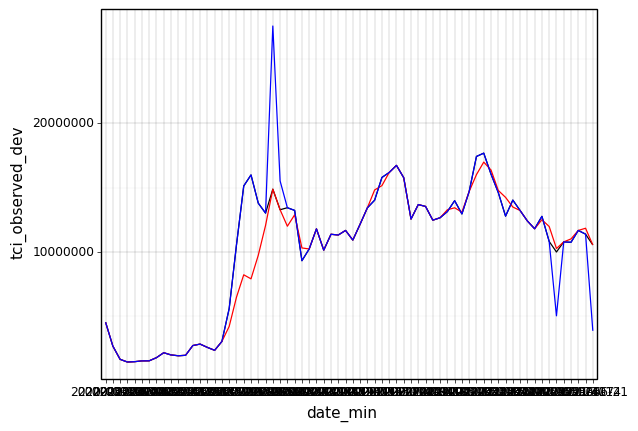

<ggplot: (8770969244529)>

In [104]:
import plotnine as p9
gg = (p9.ggplot(df_weekly_update[df_weekly_update.region_slug == 'torreon'],
                    p9.aes(x = 'date_min', y='tci_observed_dev', group = 'region_slug')) 
 + p9.geom_line() 
 + p9.geom_line(p9.aes(y = 'tci_smoothed_dev'), color = 'red')
 + p9.geom_line(p9.aes(y = 'tci_observed'), color = 'blue')
     )
gg

#### Long format 

In [105]:
df_weekly_update.head(1)

,date_min,region_slug,tci_observed,tcp_observed,tci_smoothed,tcp_smoothed,tci_observed_dev,tcp_observed_dev,tcp_smoothed_dev,tci_smoothed_dev
0,2020-03-09,aguascalientes,18414201,-0.072327,18414201.0,-0.072327,18414201,-3.5533,-3.5533,18414201.0


In [106]:
from siuba import *
df_update_long = (df_weekly_update 
 >> gather('measure', 'value', _["tci_observed":"tci_smoothed_dev"])
)

df_update_long
df_update_long['type'] = 'TCP'
tci_exist = df_update_long['measure'].isin(['tci_observed',  'tci_smoothed',
                                           'tci_observed_dev',  'tci_smoothed_dev'])
df_update_long['type'][tci_exist] = 'TCI'

/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [107]:
#df_update_long.head()
df_prev_long = pd.read_csv(f"/home/soniame/private/smooth/weekly_weekly_index_long-202105.csv", index_col=0)
df_prev_long = df_prev_long[df_prev_long.measure.isin(['tci_observed',  'tcp_observed', 'tci_cleaned', 'tcp_cleaned']) == False]
print(df_prev_long.measure.unique())

df_weekly_long = pd.concat([df_prev_long, df_update_long])
df_weekly_long.measure.unique()

['tci_cleaned_ls_4X' 'tci_cleaned_ls_20X' 'tci_cleaned_ls_10X'
 'tci_cleaned_ls_15X' 'tci_cleaned_ls_OFF' 'tci_cleaned_ls_MIX'
 'tcp_cleaned_ls_4X' 'tcp_cleaned_ls_20X' 'tcp_cleaned_ls_OFF'
 'tcp_cleaned_ls_MIX']


array(['tci_cleaned_ls_4X', 'tci_cleaned_ls_20X', 'tci_cleaned_ls_10X',
       'tci_cleaned_ls_15X', 'tci_cleaned_ls_OFF', 'tci_cleaned_ls_MIX',
       'tcp_cleaned_ls_4X', 'tcp_cleaned_ls_20X', 'tcp_cleaned_ls_OFF',
       'tcp_cleaned_ls_MIX', 'tci_observed', 'tcp_observed',
       'tci_smoothed', 'tcp_smoothed', 'tci_observed_dev',
       'tcp_observed_dev', 'tcp_smoothed_dev', 'tci_smoothed_dev'],
      dtype=object)

In [108]:
df_weekly_long.to_csv(f"/home/soniame/private/smooth/weekly_weekly_index_long-{cm}.csv")
df_weekly_long.to_csv(f"/home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/dashboard/weekly_weekly_index_long-{cm}.csv")

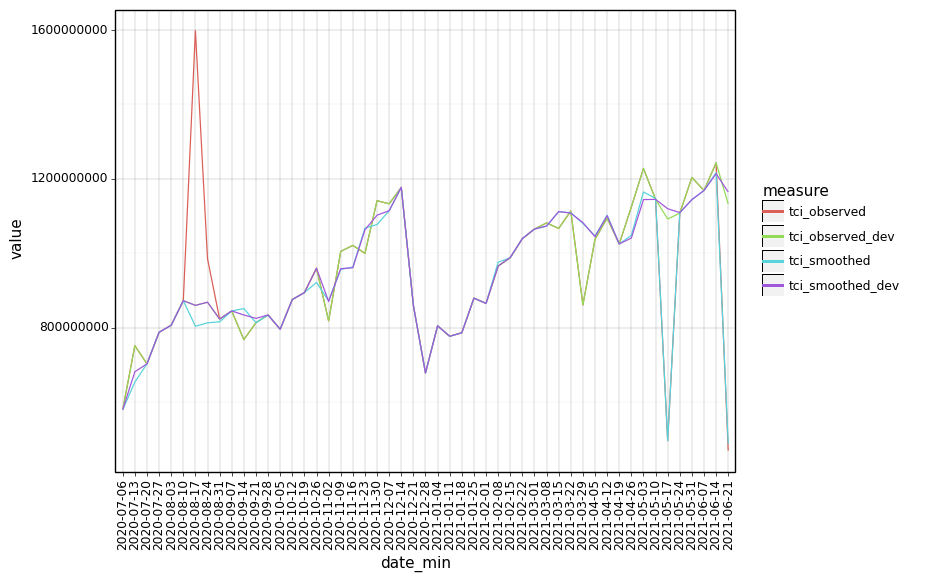

<ggplot: (8770966775381)>

In [109]:
gg = (p9.ggplot(df_weekly_long[(df_weekly_long.region_slug == 'mexicocity') & 
                              (df_weekly_long.type == 'TCI') & 
                              (df_weekly_long.date_min > '2020-07-01') &
                              (df_weekly_long.measure.isin(['tci_observed', 'tci_smoothed',
                                                           'tci_observed_dev', 'tci_smoothed_dev']))],
                    p9.aes(x = 'date_min', y='value', 
                           colour = 'measure', group = 'measure')) 
 + p9.geom_line()
 + p9.theme(axis_text_x=p9.element_text(angle=90),
                figure_size=(8, 6) )
)
gg

#### Weekly dev

In [ ]:
#from src import utils
#conn = utils.connect_athena(path='../configs/athena.yaml')

### Colombia Dev

In [46]:
df_dev_daily = pd.read_csv(f"/home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/daily/daily_daily_index_dev_max_ls20-{dev_version}.csv")
df_daily = df_dev_daily.loc[df_dev_daily.region_slug.isin(['country_colombia', 'bogota', 'barranquilla', 
                                                  'cali', 'cartagena', 'cucuta', 'medellin',
                                                  'santamarta', 'bucaramanga', 'pereira']), 
          ['date', 'region_slug', 'tci_observed', 'tcp_observed', 
           'expected_2020', 'tci_smooth', 'tcp_smooth']] \
        .rename(columns = {'tci_smooth':'tci_smoothed', 
                           'tcp_smooth':'tcp_smoothed'}) 
df_daily.shape

(4870, 7)

In [54]:
#df_daily.to_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/outputs/daniel/colombia_dev_daily_20210826.csv", index=False)
df_daily.to_csv("/home/soniame/private/daniel/colombia_dev_daily.csv")

In [47]:
df_dev_weekly = pd.read_csv(f"/home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/weekly/weekly_weekly_index_dev_max_ls20-{dev_version}.csv")
df_weekly = df_dev_weekly.loc[df_dev_weekly.region_slug.isin(['country_colombia', 'bogota', 'barranquilla', 
                                                  'cali', 'cartagena', 'cucuta', 'medellin',
                                                  'santamarta', 'bucaramanga', 'pereira']), 
                            ['week', 'region_slug', 'year', 'date_min', 'date_max', 'days_num',
                             'tci_observed', 'tcp_observed', 'expected_2020', 'tci_clean', 'tcp_clean']] \
        .rename(columns = {'tci_clean':'tci_smoothed', 
                           'tcp_clean':'tcp_smoothed'}) 
df_weekly.shape

(700, 11)

In [55]:
#df_weekly.to_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/outputs/daniel/colombia_dev_weekly.csv")
df_weekly.to_csv("/home/soniame/private/daniel/colombia_dev_weekly.csv")

In [81]:
#df_daily.loc[df_daily.region_slug.isin(['country_colombia'])]

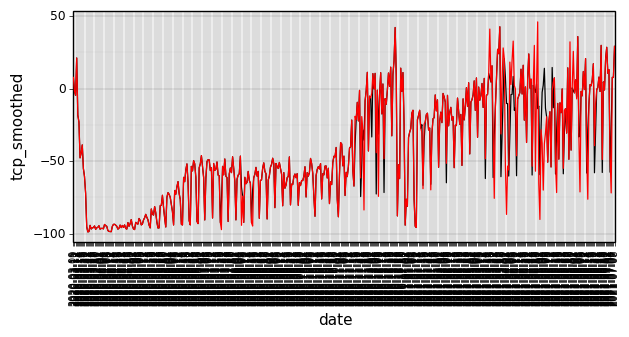

<ggplot: (8736003690969)>

In [56]:
df_pl = df_daily.loc[df_daily.region_slug.isin(['bucaramanga'])]
(p9.ggplot(df_pl, p9.aes(x = 'date', y='tcp_smoothed', group = 'region_slug')) 
 + p9.geom_line() 
 + p9.geom_line(p9.aes( y='tcp_observed'), color = 'red')
 + p9.theme(figure_size=(7, 3),
            axis_text_x=p9.element_text(size = 7, angle = 90)) )

In [57]:
#df_dev_daily[['region_slug']].drop_duplicates().to_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/outputs/daniel/region_slugs.csv")
df_dev_daily[['region_slug']].drop_duplicates().to_csv("/home/soniame/private/daniel/region_slugs.csv")

### Data Dev

In [65]:
df_dev_daily = pd.read_csv(f"/home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/daily/daily_daily_index_dev_max_ls20-{dev_version}.csv")
df_dev_daily.head()

,date,region_slug,tci_observed,expected_2020,tcp_observed,S1_Loess,S1_shift,S2_Loess,tci_clean,tcp_smooth,tci_smooth
0,2020-08-09,aguascalientes,1476292,2061580.0,-28.390264,1476292.0,1476292.0,1476292.0,1476292.0,-28.390264,1476292.0
1,2020-11-08,aguascalientes,1506272,2061580.0,-26.936039,1506272.0,1506272.0,1506272.0,1506272.0,-26.936039,1506272.0
2,2021-06-13,aguascalientes,2127337,2061580.0,3.189641,2127337.0,2127337.0,2127337.0,2127337.0,3.189641,2127337.0
3,2021-02-28,aguascalientes,1784194,2061580.0,-13.455020,1784194.0,1784194.0,1784194.0,1784194.0,-13.455020,1784194.0
4,2020-09-27,aguascalientes,1279180,2061580.0,-37.951474,1279180.0,1279180.0,1279180.0,1279180.0,-37.951474,1279180.0


In [64]:
print(df_dev_daily.date.min())
print(df_dev_daily.date.max())

2020-03-09
2021-07-08


In [96]:
df_dev_daily = pd.read_csv(f"/home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/daily/daily_daily_index_dev_max_ls20-{dev_version}.csv")
df_daily = df_dev_daily.loc[df_dev_daily.region_slug.isin(['country_mexico', 'country_brazil']) == False,
                            ['date', 'region_slug', 'tcp_observed', 'tcp_smooth']] \
        .rename(columns = {'tci_smooth':'tci_smoothed', 
                           'tcp_smooth':'tcp_smoothed'}) 

In [97]:
tab = df_daily.groupby('region_slug').agg({'date': [min, max, 'nunique']}).reset_index()
tab.to_csv("/home/soniame/private/daily_summary.csv")

In [98]:
df_daily.to_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/outputs/data/dev_daily_tcp.csv")
df_daily.head()

,date,region_slug,tcp_observed,tcp_smoothed
0,2020-08-09,aguascalientes,-28.390264,-28.390264
1,2020-11-08,aguascalientes,-26.936039,-26.936039
2,2021-06-13,aguascalientes,3.189641,3.189641
3,2021-02-28,aguascalientes,-13.455020,-13.455020
4,2020-09-27,aguascalientes,-37.951474,-37.951474


In [99]:
df_dev_weekly = pd.read_csv(f"/home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/weekly/weekly_weekly_index_dev_max_ls20-{dev_version}.csv")
df_weekly = df_dev_weekly.loc[df_dev_weekly.region_slug.isin(['country_mexico', 'country_brazil']) == False,
                              ['week', 'region_slug', 'year', 'date_min', 'date_max',
                             'tcp_observed', 'tcp_clean']] \
        .rename(columns = {'tci_clean':'tci_smoothed', 
                           'tcp_clean':'tcp_smoothed'}) 

In [100]:
tab = df_weekly.groupby('region_slug').agg({'date_max': [min, max, 'nunique']}).reset_index()
tab.to_csv("/home/soniame/private/weekly_summary.csv")

In [101]:
df_weekly.to_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/outputs/data/dev_weekly_tcp.csv")
df_weekly.head()

,week,region_slug,year,date_min,date_max,tcp_observed,tcp_smoothed
0,1,aguascalientes,2020,2020-03-09,2020-03-15,-3.553300,-3.553300
1,2,aguascalientes,2020,2020-03-16,2020-03-22,-49.831168,-49.831168
2,3,aguascalientes,2020,2020-03-23,2020-03-29,-71.341281,-71.341281
3,4,aguascalientes,2020,2020-03-30,2020-04-05,-75.377281,-75.377281
4,5,aguascalientes,2020,2020-04-06,2020-04-12,-79.895074,-79.895074


### Private observed


#### daily

In [595]:
#df_daily = pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/dev/public/daily/write_index/daily.csv", sep = ",")


In [625]:
qry = """select last_updated_utc, region_slug, region_name, country_name, 
        country_iso_code, country_idb_code, region_type, population, 
        timezone, year, month, day, dow, 
        observed, expected_2020,
        ratio_20, tcp, dashboard,
        date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
    from spd_sdv_waze_corona.dev_daily_daily_index"""
df_daily = pd.read_sql_query(qry, conn)

In [627]:
print(df_daily.shape)
# (52264, 18)
# (66490, 18)
# (67826, 18)
# (68688, 18)
# (70200, 19)
# (72360, 19)
df_daily.head()

(72360, 19)


,last_updated_utc,region_slug,region_name,country_name,country_iso_code,country_idb_code,region_type,population,timezone,year,month,day,dow,observed,expected_2020,ratio_20,tcp,dashboard,date
0,2022-01-09 20:38:37.784,br_states_mato_grosso_do_sul,Mato Grosso Do Sul,Brazil,BR,BR,state,,,2020,12,28,1,20948938,11341195.0,1.847154,84.715438,FALSE,2020-12-28
1,2022-01-09 20:38:37.784,br_states_mato_grosso_do_sul,Mato Grosso Do Sul,Brazil,BR,BR,state,,,2020,9,28,1,34443155,11341195.0,3.036995,203.699522,FALSE,2020-09-28
2,2022-01-09 20:38:37.784,br_states_mato_grosso_do_sul,Mato Grosso Do Sul,Brazil,BR,BR,state,,,2021,2,8,1,29033683,11341195.0,2.560020,156.001973,FALSE,2021-02-08
3,2022-01-09 20:38:37.784,br_states_mato_grosso_do_sul,Mato Grosso Do Sul,Brazil,BR,BR,state,,,2020,12,14,1,30834393,11341195.0,2.718796,171.879577,FALSE,2020-12-14
4,2022-01-09 20:38:37.784,br_states_mato_grosso_do_sul,Mato Grosso Do Sul,Brazil,BR,BR,state,,,2020,7,20,1,38659308,11341195.0,3.408751,240.875084,FALSE,2020-07-20


In [628]:
(df_daily[(df_daily.date >= '2021-11-01') & (df_daily.date < '2021-11-30')]
 >> group_by('date')
 >> summarize(regions = _.region_slug.nunique())
 >> arrange('date')
 >> group_by('regions')
 >> summarize(n = _.date.nunique())
)

,regions,n
0,108,29


In [629]:
(df_daily 
 >> filter(_.dashboard == 'TRUE')
 >> group_by('region_slug')
 >> summarize(n_count = _.last_updated_utc.count())
 >> arrange('n_count')
 >> group_by('n_count')
 >> summarize(n = _.region_slug.count())
)


,n_count,n
0,670,78


In [630]:
#(df_daily 
# >> filter(_.dashboard == 'TRUE')
# >> group_by('region_slug')
# >> summarize(n_count = _.last_updated_utc.count(),
#             min_date = _.date.min(), 
#             max_date = _.date.max())
# >> arrange('n_count')
#)

In [631]:
(df_daily 
 >> group_by('dashboard')
 >> summarize(n_count = _.region_slug.nunique())
) # 30 - 78

,dashboard,n_count
0,FALSE,30
1,TRUE,78


In [633]:
if False:
    print(df_daily
     >> filter(_.tcp > 200, _.dashboard == 'TRUE')
     >> group_by('dashboard', 'region_slug')
     >> summarize(n_count = _.region_slug.nunique())
    )

/home/soniame/.conda/envs/waze_coronavirus/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


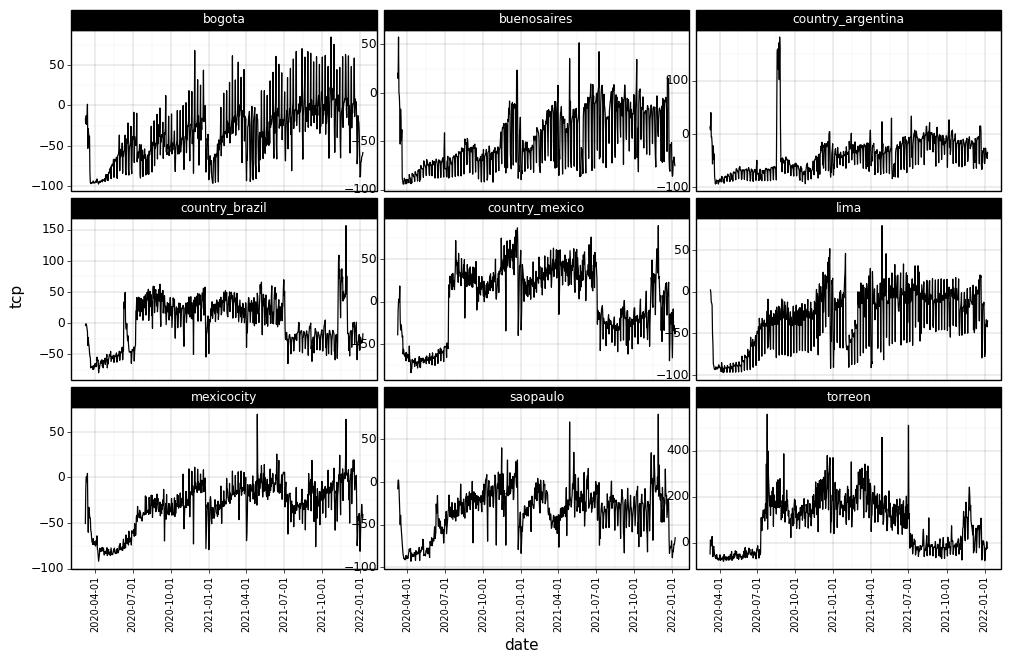

<ggplot: (8785709751981)>


In [648]:
if True: 
    #df_pl = df_daily.loc[(df_daily.region_slug.isin(['lima'])) & (df_daily.month == 7) & (df_daily.year == 2021)]
    df_pl = df_daily.loc[(df_daily.region_slug.isin(['country_mexico', 'country_brazil', 
                                                     'mexicocity', 'lima', 'torreon',
                                                    'saopaulo', 'buenosaires', 'country_argentina', 
                                                    'bogota']))]
    print(p9.ggplot(df_pl, p9.aes(x = 'date', y='tcp', group = 'region_slug')) 
     + p9.geom_line() 
     + p9.facet_wrap('region_slug', scales='free_y')
     #+ p9.geom_point()
     + p9.theme(figure_size=(12, 7),
                axis_text_x=p9.element_text(size = 7, angle = 90)) )

In [649]:
df_daily.date.max()

Timestamp('2022-01-08 00:00:00')

In [650]:
if True:
    # Remove countries columns
    df_daily.loc[df_daily.region_slug.isin(['country_brazil', 'country_mexico']), 'tcp'] = None
    df_daily.loc[df_daily.region_slug.isin(['country_brazil', 'country_mexico']), 'dashboard'] = 'FALSE'
    # Remove date column
    df_daily = df_daily.drop(columns=['date'])
df_daily.head(3)    

,last_updated_utc,region_slug,region_name,country_name,country_iso_code,country_idb_code,region_type,population,timezone,year,month,day,dow,observed,expected_2020,ratio_20,tcp,dashboard
0,2022-01-09 20:38:37.784,br_states_mato_grosso_do_sul,Mato Grosso Do Sul,Brazil,BR,BR,state,,,2020,12,28,1,20948938,11341195.0,1.847154,84.715438,FALSE
1,2022-01-09 20:38:37.784,br_states_mato_grosso_do_sul,Mato Grosso Do Sul,Brazil,BR,BR,state,,,2020,9,28,1,34443155,11341195.0,3.036995,203.699522,FALSE
2,2022-01-09 20:38:37.784,br_states_mato_grosso_do_sul,Mato Grosso Do Sul,Brazil,BR,BR,state,,,2021,2,8,1,29033683,11341195.0,2.560020,156.001973,FALSE


In [651]:
# Write
if True:
    df_daily.to_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/dev/private/daily/write_index/daily_pr.csv", index=False)

#### weekly

In [652]:
qry = """select last_updated_utc, region_slug, region_name, country_name, 
	country_iso_code, country_idb_code, region_type, population, 
	timezone,  week_number, week_number_obs, 
    min_year, min_month, min_day, max_month, max_day, 
    observed, expected_2020,
	ratio_20, tcp, dashboard,
    date_parse(concat(cast(min_year as varchar), ' ', cast(min_month as varchar), ' ', cast(min_day as varchar)), '%Y %m %e') date
from spd_sdv_waze_corona.dev_daily_weekly_index """
df_weekly = pd.read_sql_query(qry, conn)

In [653]:
print(df_weekly.shape)
# (8085, 21)
# (10516, 21)
# (10633, 21)
# (10867, 21)
# (11218, 21)
#df_weekly.head()

(11218, 22)


In [654]:
df_weekly.date.max()

Timestamp('2022-01-03 00:00:00')

In [655]:
regions_daily = df_daily[df_daily.dashboard == 'TRUE'].region_slug.unique().tolist()
df_weekly.loc[df_weekly.region_slug.isin(regions_daily) == False, 'dashboard'] = 'FALSE'
print(df_weekly.shape)

(11218, 22)


In [656]:
(df_weekly 
 >> filter(_.dashboard == 'TRUE')
 >> group_by('region_slug')
 >> summarize(n_count = _.last_updated_utc.count())
 >> arrange('n_count')
 >> group_by('n_count')
 >> summarize(n = _.region_slug.count())
)

,n_count,n
0,96,76


In [657]:
(df_weekly 
 >> group_by('dashboard')
 >> summarize(n_count = _.region_slug.nunique())
)

,dashboard,n_count
0,FALSE,41
1,TRUE,76


In [658]:
if True:
    print(df_weekly
     >> filter(_.tcp > 200, _.dashboard == 'TRUE')
     >> group_by('dashboard', 'region_slug')
     >> summarize(n_count = _.region_slug.nunique())
    )

  dashboard region_slug  n_count
0      TRUE     torreon        1


/home/soniame/.conda/envs/waze_coronavirus/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


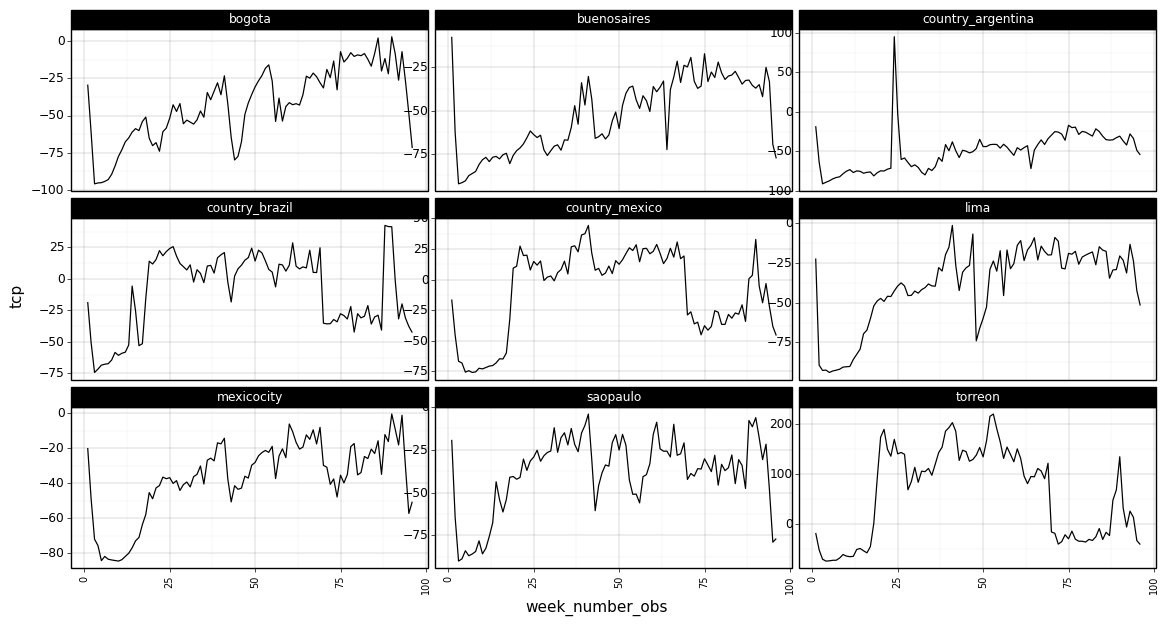

<ggplot: (8785710948349)>


In [660]:
if True: 
    df_pl = df_weekly.loc[df_weekly.region_slug.isin(['country_mexico', 'country_brazil', 
                                                     'mexicocity', 'lima', 'torreon',
                                                    'saopaulo', 'buenosaires', 'country_argentina', 
                                                    'bogota'])]
    print(p9.ggplot(df_pl, p9.aes(x = 'week_number_obs', y='tcp', group = 'region_slug')) 
     + p9.geom_line() 
     + p9.facet_wrap('region_slug', scales='free_y')          
     + p9.theme(figure_size=(14, 7),
                axis_text_x=p9.element_text(size = 7, angle = 90)) )

In [661]:
if True:
    # Remove countries columns
    df_weekly.loc[df_weekly.region_slug.isin(['country_brazil', 'country_mexico']), 'tcp'] = None
    df_weekly.loc[df_weekly.region_slug.isin(['country_brazil', 'country_mexico']), 'dashboard'] = 'FALSE'
    # Remove date column
    df_weekly = df_weekly.drop(columns=['date'])
df_weekly.head(3)

,last_updated_utc,region_slug,region_name,country_name,country_iso_code,country_idb_code,region_type,population,timezone,week_number,...,min_year,min_month,min_day,max_month,max_day,observed,expected_2020,ratio_20,tcp,dashboard
0,2022-01-09 20:37:25.121,leon,León,Mexico,MX,ME,city,1541995,America/Mexico_City,4,...,2021,1,25,1,31,33258058,38135651,0.872099,-12.790113,TRUE
1,2022-01-09 20:37:25.121,leon,León,Mexico,MX,ME,city,1541995,America/Mexico_City,25,...,2020,6,15,6,21,12702212,38135651,0.333080,-66.692028,TRUE
2,2022-01-09 20:37:25.121,leon,León,Mexico,MX,ME,city,1541995,America/Mexico_City,36,...,2021,9,6,9,12,29678365,38135651,0.778232,-22.176850,TRUE


In [662]:
# Write
if True:
    df_weekly.to_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/dev/private/daily/write_index/weekly_pr.csv", index=False)
    

### Public observed

#### daily

In [663]:
#df_daily = pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/dev/private/daily/write_index/daily_pr.csv")
df_daily.head()

,last_updated_utc,region_slug,region_name,country_name,country_iso_code,country_idb_code,region_type,population,timezone,year,month,day,dow,observed,expected_2020,ratio_20,tcp,dashboard
0,2022-01-09 20:38:37.784,br_states_mato_grosso_do_sul,Mato Grosso Do Sul,Brazil,BR,BR,state,,,2020,12,28,1,20948938,11341195.0,1.847154,84.715438,FALSE
1,2022-01-09 20:38:37.784,br_states_mato_grosso_do_sul,Mato Grosso Do Sul,Brazil,BR,BR,state,,,2020,9,28,1,34443155,11341195.0,3.036995,203.699522,FALSE
2,2022-01-09 20:38:37.784,br_states_mato_grosso_do_sul,Mato Grosso Do Sul,Brazil,BR,BR,state,,,2021,2,8,1,29033683,11341195.0,2.560020,156.001973,FALSE
3,2022-01-09 20:38:37.784,br_states_mato_grosso_do_sul,Mato Grosso Do Sul,Brazil,BR,BR,state,,,2020,12,14,1,30834393,11341195.0,2.718796,171.879577,FALSE
4,2022-01-09 20:38:37.784,br_states_mato_grosso_do_sul,Mato Grosso Do Sul,Brazil,BR,BR,state,,,2020,7,20,1,38659308,11341195.0,3.408751,240.875084,FALSE


In [664]:
df_daily = df_daily[df_daily.dashboard.isin([True, 'TRUE'])].drop(['observed', 'expected_2020', 'dashboard', 'ratio_20'], axis=1)
df_daily.shape

(50920, 14)

In [665]:
if True:
    df_daily.to_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/dev/public/daily/write_index/daily_pu.csv", index=False)

#### weekly

In [666]:
#df_weekly = pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/dev/private/daily/write_index/weekly_pr.csv")
df_weekly.head(3)

,last_updated_utc,region_slug,region_name,country_name,country_iso_code,country_idb_code,region_type,population,timezone,week_number,...,min_year,min_month,min_day,max_month,max_day,observed,expected_2020,ratio_20,tcp,dashboard
0,2022-01-09 20:37:25.121,leon,León,Mexico,MX,ME,city,1541995,America/Mexico_City,4,...,2021,1,25,1,31,33258058,38135651,0.872099,-12.790113,TRUE
1,2022-01-09 20:37:25.121,leon,León,Mexico,MX,ME,city,1541995,America/Mexico_City,25,...,2020,6,15,6,21,12702212,38135651,0.333080,-66.692028,TRUE
2,2022-01-09 20:37:25.121,leon,León,Mexico,MX,ME,city,1541995,America/Mexico_City,36,...,2021,9,6,9,12,29678365,38135651,0.778232,-22.176850,TRUE


In [667]:
df_weekly = df_weekly[df_weekly.dashboard.isin([True, 'TRUE'])].drop(['observed', 'expected_2020', 'dashboard', 'ratio_20'], axis=1)
df_weekly.shape

(7296, 17)

In [668]:
if True:
    df_weekly.to_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/dev/public/daily/write_index/weekly_pu.csv", index=False)

In [669]:
df_weekly[df_weekly.week_number == 90]

(df_weekly
 >> group_by('week_number_obs')
 >> summarize(day = _.min_day.min(), )
)

,week_number_obs,day
0,1,9
1,2,16
2,3,23
3,4,30
4,5,6
...,...,...
91,92,6
92,93,13
93,94,20
94,95,27
